### First model iterations
In this notebook i start iterating through classification models

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

from src import cleaning_functions as cfs
from src import preprocessing_functions as pfs
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier 
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error, recall_score, f1_score, make_scorer

### Bring in data

In [3]:
df = cfs.cleaned_dataframe()

In [4]:
y = df['target']
X = df.drop('target', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 2015, test_size = .2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, random_state = 2015, test_size = .25)
rus = RandomUnderSampler(random_state=2015)
X_tr_res, y_tr_res = rus.fit_resample(X_tr, y_tr)
X_tr, X_val, X_test = pfs.ohe_train_and_test_features(X_tr_res, X_val, X_test)

In [5]:
df.describe()

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,target
count,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,...,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000,762093.000000
mean,25.767919,2582.696729,258275.114520,2.087787,24.325059,406.673250,16.049422,0.042402,0.800270,0.035122,...,0.035090,0.008264,0.001161,0.000424,0.001164,0.000227,0.000186,0.000097,0.004490,2.385175
std,5.807569,581.174171,58117.488779,0.655105,65.034593,226.780292,5.493903,0.201504,0.399798,0.184088,...,0.184008,0.090531,0.034058,0.020583,0.034096,0.015065,0.013649,0.009854,0.066859,0.820149
min,12.000000,1201.000000,120101.000000,1.000000,0.000000,70.000000,6.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,22.000000,2204.000000,220402.000000,2.000000,9.000000,280.000000,12.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,24.000000,2410.000000,241004.000000,2.000000,16.000000,358.000000,16.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,30.000000,3010.000000,301006.000000,2.000000,27.000000,470.000000,18.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,36.000000,3611.000000,361108.000000,9.000000,999.000000,5000.000000,99.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [31]:
def recall_score_class3(y_true, y_pred):
    return recall_score(y_true, y_pred, average=None)[2]

def scorer_recall3():
    scorer = make_scorer(recall_score_class3)
    return scorer

def f1_score_class3(y_true, y_pred):
    return f1_score(y_true, y_pred, average=None)[2]

def scorer_f13():
    scorer = make_scorer(f1_score_class3)
    return scorer

recall3 = scorer_recall3()
f13 = scorer_f13()

### Modeling with ensemble classifiers
#### first up bagging

In [7]:
bgc = BaggingClassifier(random_state=2015)
print('Recall Score for class 3 : ', cross_val_score(bgc, X_tr, y_tr_res, scoring=recall3, cv=3))

Recall Score for class 3 :  [0.66604361 0.67426519 0.67144323]


In [8]:
bgc2 = BaggingClassifier(n_estimators=100, random_state=2015 )
print('Recall Score for class 3 : ', cross_val_score(bgc2, X_tr, y_tr_res, scoring=recall3, cv=3))

Recall Score for class 3 :  [0.69774601 0.70398739 0.70292458]


that took quite some time(7 mins), slightly high bias (missed 30% of target), but low variance between these cv folds!

In [27]:
bgc2.fit(X_tr, y_tr_res)

BaggingClassifier(n_estimators=100, random_state=2015)

In [29]:
recall_score(y_val, bgc2.predict(X_val), average=None)

array([0.72513437, 0.55365026, 0.70702564])

#### Let's try RandomForestClassifier next

In [30]:
rfc1 = RandomForestClassifier(random_state=2015)
print('Recall Score for Class 3 : ', cross_val_score(rfc1, X_tr, y_tr_res, scoring=recall3, cv=3))                                                   

Recall Score for Class 3 :  [0.70317024 0.70772557 0.70538005]


In [33]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', 1],
    'criterion': ["gini", "entropy"],
    
}

# Initializing gridsearch with 3-fold cross-validation.
#gs = GridSearchCV(estimator=rfc1, param_grid=param_grid, cv=3, scoring=recall3, verbose=1)

In [35]:
#gs.fit(X_tr, y_tr_res)

Tried running a grid search, but had to interrupt since the grid search kept running for over 30 minutes without any results. Must manually try changing hyperparameters and improve the recall for damage_grade 3

In [38]:
rfc1 = RandomForestClassifier(random_state=2015)
rfc1.fit(X_tr, y_tr_res)

RandomForestClassifier(random_state=2015)

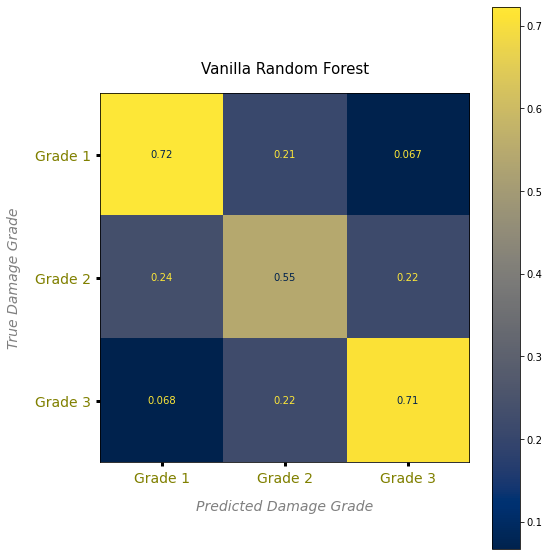

In [42]:
f,ax = plt.subplots(figsize=((8,8)))
plot_confusion_matrix(rfc1, X_val, y_val, normalize='true',
                     display_labels=['Grade 1',
                                      'Grade 2',
                                      'Grade 3'], ax=ax, cmap='cividis')
ax.set_title('Vanilla Random Forest', fontsize=15, pad=20)
ax.tick_params(labelsize=14, labelcolor='olive' ,width=3, pad=5, length=4)
ax.set_xlabel('Predicted Damage Grade', fontsize=14, labelpad=14, fontstyle='italic', color='grey')
ax.set_ylabel('True Damage Grade', fontsize=14, labelpad=14, fontstyle='italic', color='grey')
f.tight_layout()

f.savefig('../../report/figures/fsm.png', format='png', transparent=True)
f.show();

In [11]:
Xy_train = pd.concat([X_tr, y_tr_res], axis=1)
Xy_train.shape

(245571, 69)

In [12]:
Xy_train_resampled = Xy_train.sample(frac=.4, random_state=2015)

In [17]:
Xy_train_resampled.target.value_counts()

3.0    32881
2.0    32785
1.0    32562
Name: target, dtype: int64

In [18]:
X_train_red = Xy_train_resampled.drop('target', axis =1)
y_train_red = Xy_train_resampled['target']

In [20]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_features': ['sqrt', 'log2', 1]
}

In [21]:
rf = RandomForestClassifier(random_state=2015)
gs = GridSearchCV(rf, param_grid=param_grid, scoring=recall3, cv=3 )

In [23]:
gs.fit(X_train_red, y_train_red)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2015),
             param_grid={'max_features': ['sqrt', 'log2', 1],
                         'n_estimators': [50, 100, 150]},
             scoring=make_scorer(recall_score_class3))

In [24]:
gs.__dict__

{'scoring': make_scorer(recall_score_class3),
 'estimator': RandomForestClassifier(random_state=2015),
 'n_jobs': None,
 'iid': 'deprecated',
 'refit': True,
 'cv': 3,
 'verbose': 0,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'n_estimators': [50, 100, 150],
  'max_features': ['sqrt', 'log2', 1]},
 'multimetric_': False,
 'best_index_': 2,
 'best_score_': 0.7038716148228258,
 'best_params_': {'max_features': 'sqrt', 'n_estimators': 150},
 'best_estimator_': RandomForestClassifier(max_features='sqrt', n_estimators=150, random_state=2015),
 'refit_time_': 22.957879781723022,
 'scorer_': make_scorer(recall_score_class3),
 'cv_results_': {'mean_fit_time': array([ 4.35823456,  8.7947251 , 13.86573736,  4.30581093,  8.57244515,
         12.90090799,  3.31211599,  6.64144373,  9.91731238]),
  'std_fit_time': array([0.01499735, 0.06212084, 0.06620095, 0.02779853, 0.01698036,
         0.05219482, 0.01032622, 0.03819095, 0.08068718]),
  'mean_s

In [25]:
gs.best_params_

{'max_features': 'sqrt', 'n_estimators': 150}

In [26]:
rfc2 = RandomForestClassifier(random_state=2015, max_features='sqrt', n_estimators= 150)
rfc2.fit(X_tr, y_tr_res)

RandomForestClassifier(max_features='sqrt', n_estimators=150, random_state=2015)

In [27]:
print('Recall Score : ',recall_score(y_val, rfc2.predict(X_val), average=None))

Recall Score :  [0.72280935 0.54733847 0.71031211]


In [28]:
rfc3 = RandomForestClassifier(random_state=2015, max_features='sqrt', n_estimators= 300)
print('Recall Score for Class 3 : ', cross_val_score(rfc3, X_tr, y_tr_res, scoring=recall3, cv=3)) 

Recall Score for Class 3 :  [0.70507605 0.70875174 0.70680935]


In [29]:
rfc3.fit(X_tr, y_tr_res)

RandomForestClassifier(max_features='sqrt', n_estimators=300, random_state=2015)

In [30]:
print('Recall Score : ',recall_score(y_val, rfc3.predict(X_val), average=None))

Recall Score :  [0.72244701 0.54690065 0.71159622]
